In [508]:
import os

from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import classification_report, accuracy_score, make_scorer
from sklearn.model_selection import cross_validate
from sklearn.svm import SVC

import numpy
from functools import reduce
import pandas
import seaborn

from lab_v2.io import read_file

In [509]:
# FILE PATHS
DRAW_T03 = './data/draw/draw-T0.3.jsonl' 

ATTRIBUTES = ["majority_distance", "majority_distance_squared", "shannon_entropy", "gini_impurity"]
CLASS = 'majority_correct'

FILE_PATH = DRAW_T03

In [510]:
data = read_file(FILE_PATH)
data.head(1)

,majority_distance,majority_distance_squared,shannon_entropy,gini_impurity,majority_correct
0,0.21279,0.04528,0.746033,0.445,True


## **Data exploration**

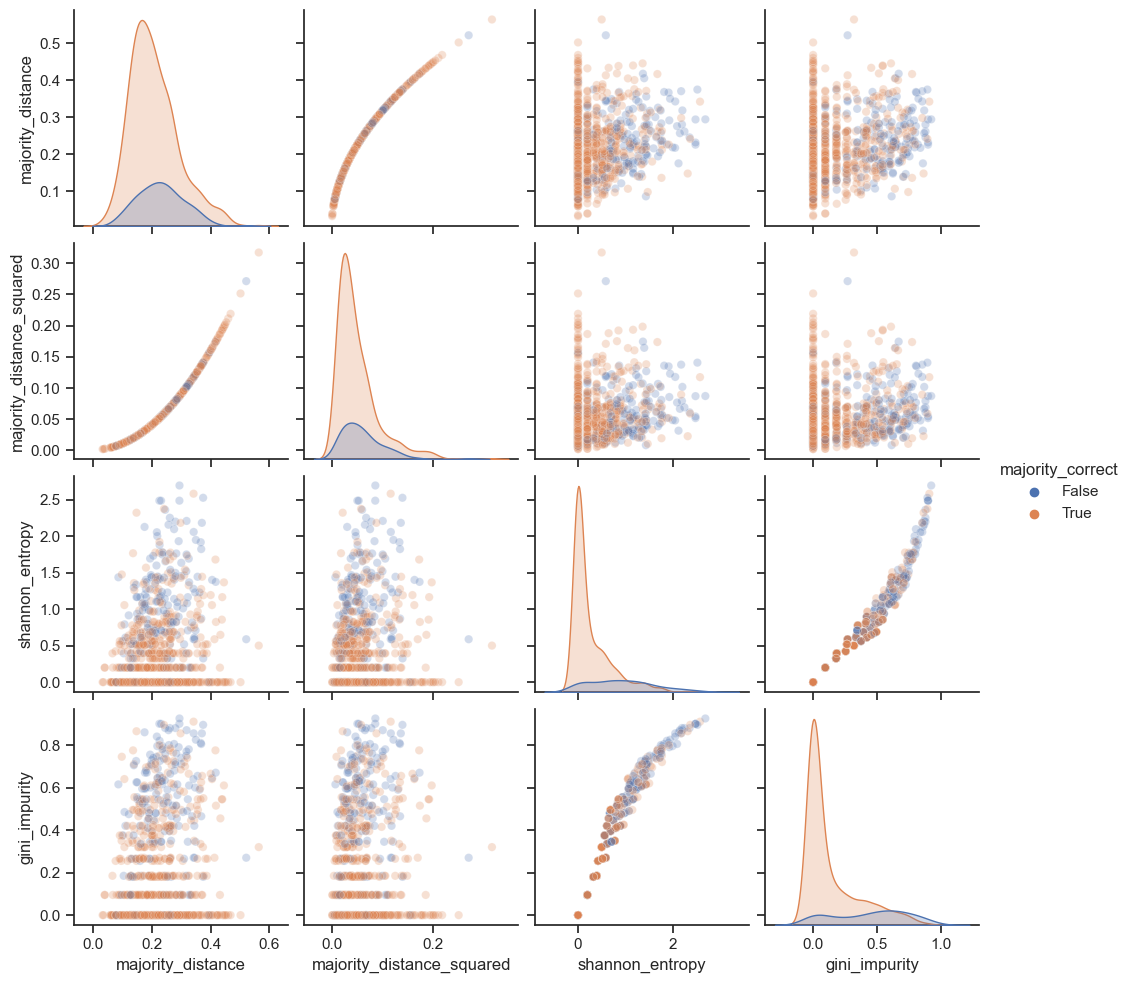

In [511]:
seaborn.set_theme(style='ticks')
seaborn.pairplot(data, hue="majority_correct", plot_kws={'alpha': 0.25})
print('')

In [512]:
data_x = data[ATTRIBUTES]
data_y = data[CLASS]

In [513]:
classification_reports = []
def classification_report_scorer(y_true, y_pred):
    classification_reports.append(classification_report(y_true, y_pred))
    return accuracy_score(y_true, y_pred)

In [514]:
def report_average(*args):
    report_list = list()
    for report in args:
        splited = [' '.join(x.split()) for x in report.split('\n\n')]
        header = [x for x in splited[0].split(' ')]
        data = numpy.array(splited[1].split(' ')).reshape(-1, len(header) + 1)
        data = numpy.delete(data, 0, 1).astype(float)
        rest = splited[2].split(' ')
        accuarcy =numpy.array([0, 0, rest[1], rest[2]]).astype(float).reshape(-1, len(header))
        macro_avg = numpy.array([rest[5:9]]).astype(float).reshape(-1, len(header))
        weighted_avg = numpy.array([rest[11:]]).astype(float).reshape(-1, len(header))
        #avg_total = numpy.array([x for x in avg]).astype(float).reshape(-1, len(header))
        df = pandas.DataFrame(numpy.concatenate((data, accuarcy,macro_avg,weighted_avg)), columns=header)
        report_list.append(df)
    res = reduce(lambda x, y: x.add(y, fill_value=0), report_list) / len(report_list)
    return res.rename(index={res.index[-3]: 'accuracy',res.index[-2]: 'macro_avg',res.index[-1]: 'weighted_avg'})

In [515]:
class ReportAverage:
    def __init__(self):
        self.classification_reports = []

    def classification_report_scorer(self, y_true, y_pred):
        self.classification_reports.append(classification_report(y_true, y_pred))
        return accuracy_score(y_true, y_pred)
    
    def average_report(self):
        average = report_average(*self.classification_reports)
        return {
            'precision_True': average.loc[0]['precision'],
            'recall_True': average.loc[0]['recall'],
            'f1-score_True': average.loc[0]['f1-score'],
            'precision_False': average.loc[1]['precision'],
            'recall_False': average.loc[1]['recall'],
            'f1-score_False': average.loc[1]['f1-score'],
            'accuracy': average.loc['accuracy']['f1-score']
        }

In [516]:
scorer = ReportAverage()
cross_validate(RandomForestClassifier(), data_x, data_y, scoring=make_scorer(scorer.classification_report_scorer))
scorer.average_report().values()

dict_values([0.46799999999999997, 0.40800000000000003, 0.438, 0.8619999999999999, 0.892, 0.874, 0.8])

In [517]:
class MLExploration:
    TEMPLATE_DICT = {
        'model': 0, 
        'hyperparameters': 0, 
        'precision_True': 0, 
        'recall_True': 0, 
        'f1_True': 0, 
        'precision_False': 0, 
        'recall_False': 0, 
        'f1_False': 0, 
        'accuracy': 0
    }

    def __init__(self, data_x, data_y, output_file_path):
        self.data_x = data_x
        self.data_y = data_y
        self.output_file_path = output_file_path
        self.explored_models = pandas.DataFrame([MLExploration.TEMPLATE_DICT])
        if os.path.exists(output_file_path): 
            self.explored_models = pandas.read_json(output_file_path, orient='split')

    def explore_model(self, model, hyperparameters):
        index = MLExploration.hash(model, hyperparameters)
        if index in self.explored_models.index: return self.explored_models.loc[index]

        scorer = ReportAverage()
        cross_validate(RandomForestClassifier(), data_x, data_y, scoring=make_scorer(scorer.classification_report_scorer))

        self.explored_models.loc[index] = [
            str(model), 
            MLExploration.hash_hyperparameters(hyperparameters),
            *scorer.average_report().values()
        ]
        self.explored_models.to_json(self.output_file_path, orient='split')

    def hash_hyperparameters(hyperparameters):
       return str(sorted(hyperparameters.items(), key=lambda x:x[0]))
    
    def hash(model, hyperparameters):
        model = str(model)
        hyperparameters = MLExploration.hash_hyperparameters(hyperparameters)
        return str((model, hyperparameters))

In [518]:
csqa = MLExploration(data_x, data_y, 'cache/csqa/csqa-T0.3.json')

ValueError: All arrays must be of the same length

In [ ]:
csqa.explore_model(RandomForestClassifier, {})
csqa.explore_model(GaussianNB, {})
csqa.explore_model(RandomForestClassifier, {})
csqa.explored_models

,model,hyperparameters,precision_True,recall_True,f1_True,precision_False,recall_False,f1_False,accuracy
0,0,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000
"(""<class 'sklearn.ensemble._forest.RandomForestClassifier'>"", '[]')",<class 'sklearn.ensemble._forest.RandomForestC...,[],0.452,0.400,0.422,0.858,0.882,0.870,0.790
"(""<class 'sklearn.naive_bayes.GaussianNB'>"", '[]')",<class 'sklearn.naive_bayes.GaussianNB'>,[],0.482,0.414,0.446,0.864,0.890,0.878,0.802
